In [14]:
#pip install deepparse

In [15]:
from deepparse.parser import AddressParser

In [16]:
address_parser = AddressParser(model_type='bpemb')

Loading the embeddings model


In [17]:
import numpy as np
import pandas as pd 
df = pd.read_csv('data/addresses_and_tweets.csv')
df = df.drop_duplicates(subset='text').reset_index(drop=True)

def balance_classes(df, column_name):
    """Balance the classes of a binary column in a dataframe."""
    counts = df[column_name].value_counts()
    # Check if classes are already balanced
    if counts.min() == counts.max():
        return df
    # Identify majority and minority classes
    majority_class = counts.idxmax()
    minority_class = counts.idxmin()
    # Randomly select instances from majority class to remove
    majority_indices = df[df[column_name] == majority_class].index
    num_instances_to_remove = len(majority_indices) - counts[minority_class]
    indices_to_remove = np.random.choice(majority_indices, size=num_instances_to_remove, replace=False)
    # Remove instances from majority class
    df = df.drop(indices_to_remove)
    return df.reset_index(drop=True)

df = balance_classes(df, 'is_address').sample(10000)[['text', 'is_address']]
df.is_address.value_counts()


0    5006
1    4994
Name: is_address, dtype: int64

In [18]:
df

,text,is_address
1409529,199 faywood avenue apt 281 02128,1
733080,sending a thanks to mother nature for the thun...,0
236105,"@purelibertine awww, my poor little baby",0
1511307,11 woodcliff street apt 211 02125,1
126505,staying awake for apparently no reason.,0
...,...,...
1327203,108 washington street 6 02135,1
143708,where's my picture?,0
1133137,19 harvest ln hartford windsor vt 05001,1
1260133,14 hackensack circle 02467,1


In [19]:
def func_is_address(parsed: dict):
    street_number = parsed.get('StreetNumber')
    street_name   = parsed.get('StreetName')
    postal_code   = parsed.get('PostalCode')    

    if (not street_name) or (not street_number) or (not postal_code):
        return False
    return True

def process(text: str):
    parsed = address_parser(text)
    is_address = func_is_address(parsed=parsed.to_dict())
    return is_address

df['prediction'] = df['text'].apply(process)


In [20]:
df['prediction'] = df['prediction'].astype(int)


In [21]:
df

,text,is_address,prediction
1409529,199 faywood avenue apt 281 02128,1,1
733080,sending a thanks to mother nature for the thun...,0,0
236105,"@purelibertine awww, my poor little baby",0,0
1511307,11 woodcliff street apt 211 02125,1,1
126505,staying awake for apparently no reason.,0,0
...,...,...,...
1327203,108 washington street 6 02135,1,1
143708,where's my picture?,0,0
1133137,19 harvest ln hartford windsor vt 05001,1,1
1260133,14 hackensack circle 02467,1,1


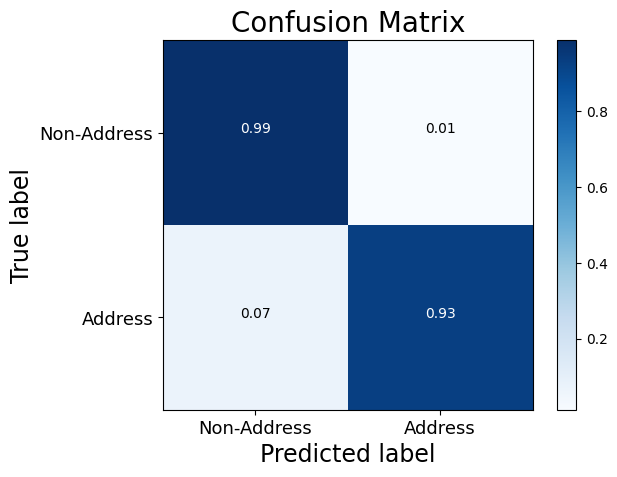

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
y_true = df['is_address']
y_pred = df['prediction']
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)


class_names = ['Non-Address', 'Address']
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")
plt.show()


In [23]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression #, SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc

y_true = df['is_address']
y_pred = df['prediction']

print('AUC: ', roc_auc_score(y_true, y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


AUC:  0.9569636980277252


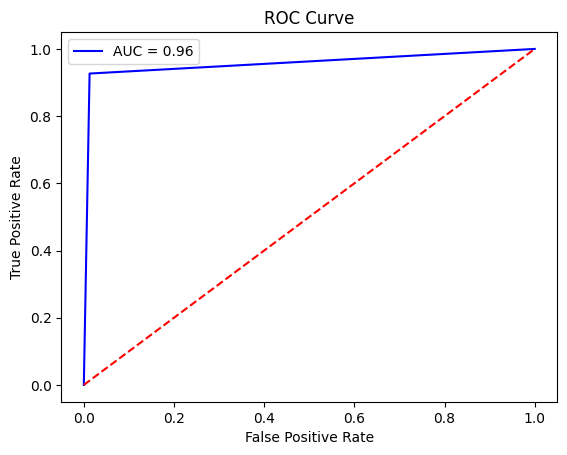

In [24]:
import matplotlib.pyplot as plt
# Plot ROC curve
plt.plot(false_positive_rate, true_positive_rate, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [25]:
%%timeit
process('hahah 123')

2.09 ms ± 75.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
